# Implement a plain end2end tensorflow model pipeline with EDA and visualizations etc.,. for this problem - using wide and deep model DNN model and proper feature engineering and preprocessing 

##Code reference: https://colab.research.google.com/drive/1xS2YjhCYGnOrsyVRKxqN-PvdFROSnDvM?authuser=1#scrollTo=0hkZkAFvWJF1

In [1]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

     |████████████████████████████████| 1.6MB 5.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [2]:
# TODO(b/178712706): Stop using legacy resolver after PIP issue is resolved.
!pip install -U --use-deprecated=legacy-resolver tfx

distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 2.3 MB 5.4 MB/s 
     |████████████████████████████████| 17.7 MB 1.3 MB/s 
     |████████████████████████████████| 2.2 MB 41.6 MB/s 
     |████████████████████████████████| 1.2 MB 43.7 MB/s 
     |████████████████████████████████| 1.4 MB 46.9 MB/s 
     |████████████████████████████████| 89 kB 5.7 MB/s 
     |████████████████████████████████| 400 kB 37.3 MB/s 
     |████████████████████████████████| 1.7 MB 46.8 MB/s 
     |████████████████████████████████| 2.9 MB 44.1 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |█████████████

In [1]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
import tfx
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.4.1
TFX version: 0.29.0


In [2]:
%load_ext tensorboard

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

device = "gpu"


2.4.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Used the NYC taxi data

In [4]:
traindf = pd.read_csv('/content/drive/MyDrive/new-york-city-taxi-fare-prediction/Copy of train-sample.csv',nrows=15000,sep=',',engine='python')
#traindf=traindf.drop(['key'],axis=1)
traindf.head()
#evaldf = df[~msk]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                15000 non-null  object 
 1   fare_amount        15000 non-null  float64
 2   pickup_datetime    15000 non-null  object 
 3   pickup_longitude   15000 non-null  float64
 4   pickup_latitude    15000 non-null  float64
 5   dropoff_longitude  15000 non-null  float64
 6   dropoff_latitude   15000 non-null  float64
 7   passenger_count    15000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 937.6+ KB


#Feature engineering 

In [6]:
traindf['pickup_datetime'] = traindf['pickup_datetime'].astype('datetime64[ns]')

In [7]:
traindf['trip_start_month']=traindf.pickup_datetime.dt.month
traindf['trip_start_hour']=traindf.pickup_datetime.dt.hour
traindf['trip_start_day']=traindf.pickup_datetime.dt.day
#traindf['trip_start_timestamp']=
traindf = traindf[['fare_amount','trip_start_month','trip_start_hour','trip_start_day','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count'	]] 

In [8]:
traindf.head()

,fare_amount,trip_start_month,trip_start_hour,trip_start_day,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,6,17,15,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,1,16,5,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,8,0,18,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,4,4,21,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,3,7,9,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [9]:
traindf['trip_start_month'] = traindf['trip_start_month'].astype('str')
traindf['trip_start_hour'] = traindf['trip_start_hour'].astype('str')
traindf['trip_start_day'] = traindf['trip_start_day'].astype('str')

In [10]:
traindf=traindf.drop(['pickup_datetime'],axis=1)
traindf[traindf['fare_amount']=='26:21.0']

,fare_amount,trip_start_month,trip_start_hour,trip_start_day,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


In [11]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

traindf = traindf.apply(euclidean, axis=1)
traindf.head()  

,fare_amount,trip_start_month,trip_start_hour,trip_start_day,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.5,6,17,15,-73.844311,40.721319,-73.841610,40.712278,1,0.943584
1,16.9,1,16,5,-74.016048,40.711303,-73.979268,40.782004,1,7.969567
2,5.7,8,0,18,-73.982738,40.761270,-73.991242,40.750562,2,1.367404
3,7.7,4,4,21,-73.987130,40.733143,-73.991567,40.758092,1,2.534047
4,5.3,3,7,9,-73.968095,40.768008,-73.956655,40.783762,1,1.946952


In [12]:
traindf[traindf['fare_amount']=='2009-06-15 17:26:21.0000001']

,fare_amount,trip_start_month,trip_start_hour,trip_start_day,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance


In [13]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        15000 non-null  float64
 1   trip_start_month   15000 non-null  object 
 2   trip_start_hour    15000 non-null  object 
 3   trip_start_day     15000 non-null  object 
 4   pickup_longitude   15000 non-null  float64
 5   pickup_latitude    15000 non-null  float64
 6   dropoff_longitude  15000 non-null  float64
 7   dropoff_latitude   15000 non-null  float64
 8   passenger_count    15000 non-null  int64  
 9   distance           15000 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.1+ MB


#EDA for the NYC taxi Data set with 15000 Samples

##Distribution of Fare_amount

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


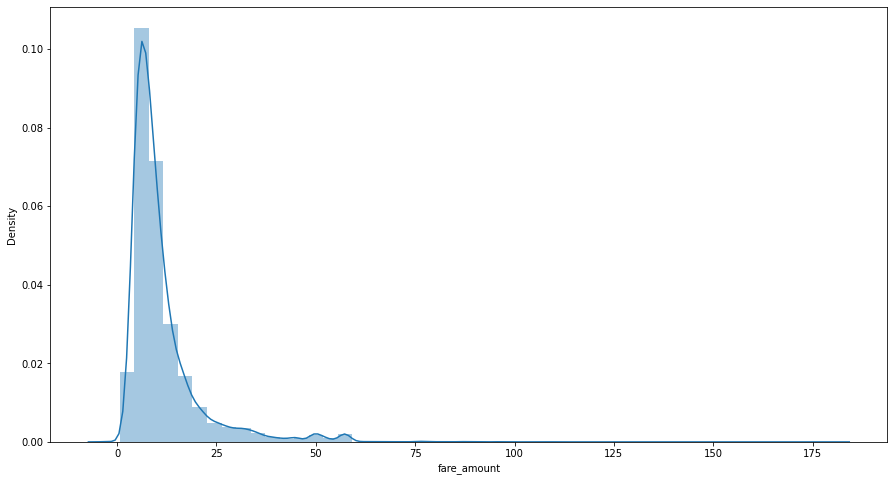

In [14]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(traindf['fare_amount'])

##Plot locations with heatmap intensity as per the FARE

In [15]:
##Plot locations with heatmap intensity as per the FARE
m = folium.Map()
sw = traindf[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = traindf[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(traindf['pickup_latitude'], traindf['pickup_longitude'], traindf['fare_amount']), radius = 10))
m.fit_bounds([sw, ne])
m

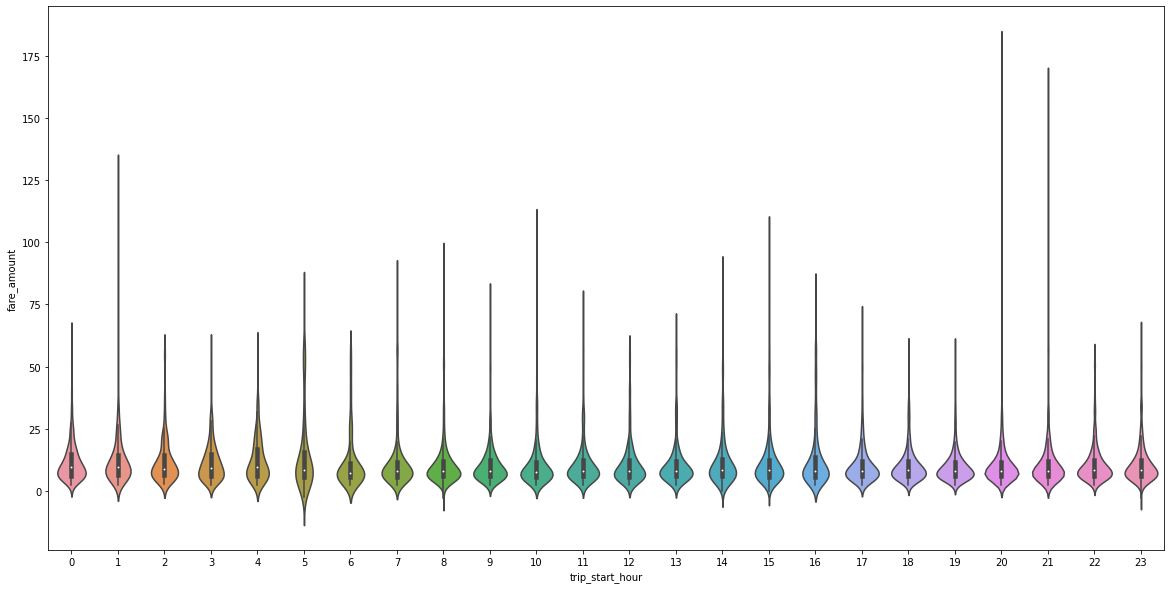

In [16]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare_amount'])

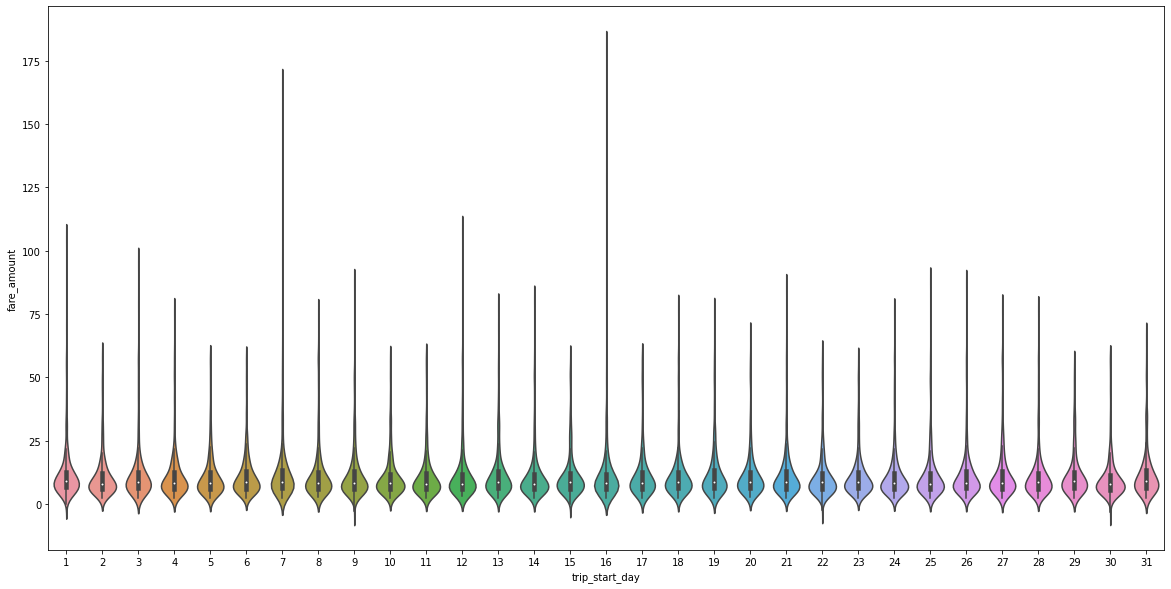

In [17]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_day'].astype(int), y=traindf['fare_amount'])

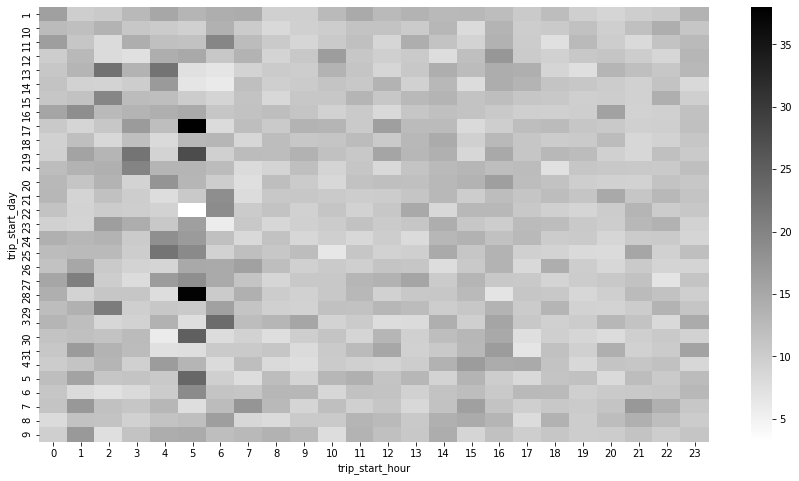

In [18]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare_amount'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

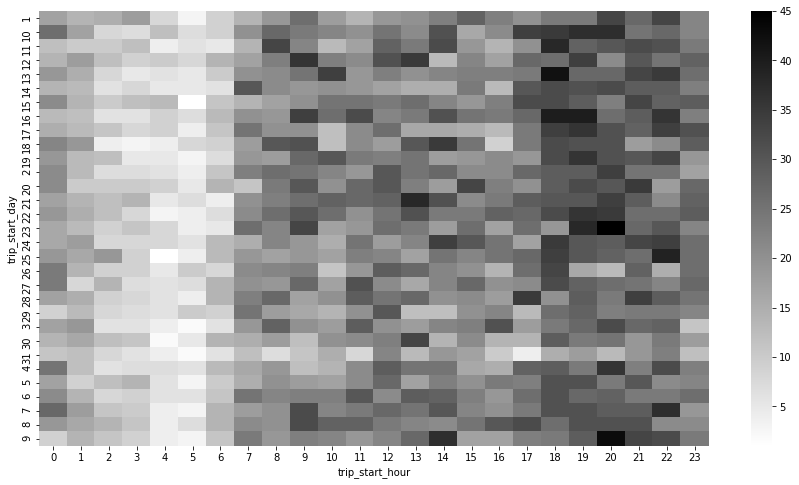

In [19]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

##Fair Vs distance plot( Colored by Trip Start Hour )

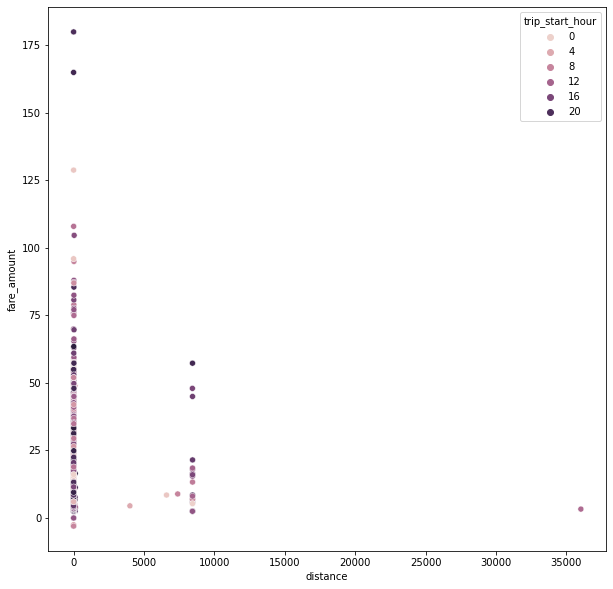

In [20]:

plt.figure(figsize=(10, 10))
sns.scatterplot(x=traindf['distance'], y=traindf['fare_amount'], hue=traindf['trip_start_hour'].astype(int))

In [21]:
df = pd.read_csv('/content/drive/MyDrive/new-york-city-taxi-fare-prediction/Copy of train-sample.csv',nrows=15000,sep=',',engine='python')


In [22]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [23]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

12745
2255


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [24]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12745 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                12745 non-null  object 
 1   fare_amount        12745 non-null  float64
 2   pickup_datetime    12745 non-null  object 
 3   pickup_longitude   12745 non-null  float64
 4   pickup_latitude    12745 non-null  float64
 5   dropoff_longitude  12745 non-null  float64
 6   dropoff_latitude   12745 non-null  float64
 7   passenger_count    12745 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 896.1+ KB


##Quantile Bucketization of latitude and longitude

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

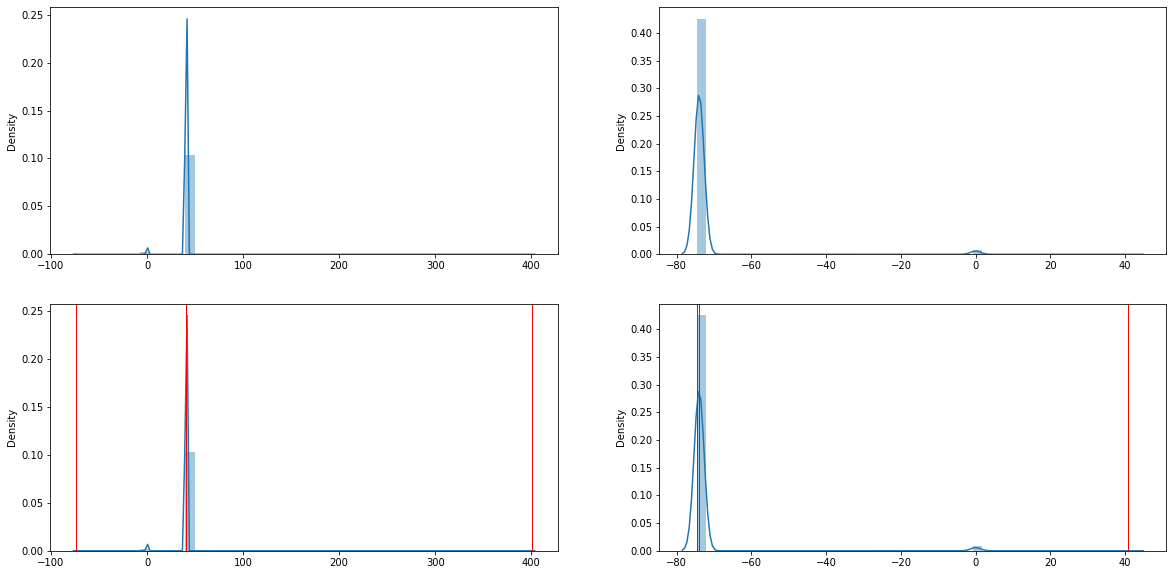

In [25]:


bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]


bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])

#Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

##Feature engineering functions

In [26]:
###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5
  features['trip_start_year'] = (tf.strings.substr(features['pickup_datetime'], 0, 4))
  features['trip_start_month'] = (tf.strings.substr(features['pickup_datetime'], 5, 2))
  features['trip_start_day'] =(tf.strings.substr(features['pickup_datetime'], 8, 2))
  features['trip_start_hour'] = (tf.strings.substr(features['pickup_datetime'], 11, 2))
  
  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [27]:
traindf.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

#Data Pipeline

In [28]:
###############################
###Data Input pipeline function

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'fare_amount'
CSV_COLUMNS

# Set default values for each CSV column( Including Y column )
#DEFAULTS = [[0.0],['1'],['1'],,[0.0],[0.0],[0.0],[0.0],[0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        print(filename)
        file_list = tf.io.gfile.glob(filename)
        print(file_list)
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   #column_names=None
                                                   column_names=CSV_COLUMNS,
                                                   #select_columns=['fare_amount','pickup_datetime', 'pickup_longitude', 'pickup_latitude',
                                                   #                'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
                                                   column_defaults=None,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        #prediction
        if mode == tf.estimator.ModeKeys.PREDICT:
            label_name=None
            select_columns=['pickup_datetime', 'pickup_longitude',
                            'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                            'passenger_count']
        else:
            label_name ='fare_amount'
            select_columns = ['fare_amount', 'pickup_datetime', 'pickup_longitude',
                              'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                              'passenger_count']
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [29]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = "/content/drive/MyDrive/new-york-city-taxi-fare-prediction/Copy of train*.csv"
eval_file

fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)


/content/drive/MyDrive/new-york-city-taxi-fare-prediction/Copy of train*.csv
['/content/drive/MyDrive/new-york-city-taxi-fare-prediction/Copy of train-sample.csv', '/content/drive/MyDrive/new-york-city-taxi-fare-prediction/Copy of train.csv']
(OrderedDict([('key', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'47:40.0', b'37:10.0', b'2009-02-18 20:58:31.0000002',
       b'2011-08-24 19:55:00.00000025', b'15:00.0',
       b'2011-09-10 23:51:43.0000003', b'39:00.0',
       b'2010-05-22 19:26:00.00000016', b'05:10.0',
       b'2013-07-21 02:50:00.00000046'], dtype=object)>), ('pickup_datetime', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'2014-10-24 00:47:40 UTC', b'2010-03-09 23:37:10 UTC',
       b'2009-02-18 20:58:31 UTC', b'2011-08-24 19:55:00 UTC',
       b'2011-03-03 14:15:00 UTC', b'2011-09-10 23:51:43 UTC',
       b'2011-07-20 13:39:00 UTC', b'2010-05-22 19:26:00 UTC',
       b'2010-12-07 14:05:10 UTC', b'2013-07-21 02:50:00 UTC'],
      dtype=object)>), ('pickup

<DatasetV1Adapter shapes: (OrderedDict([(key, (None,)), (pickup_datetime, (None,)), (pickup_longitude, (None,)), (pickup_latitude, (None,)), (dropoff_longitude, (None,)), (dropoff_latitude, (None,)), (passenger_count, (None,)), (distance, (None,)), (trip_start_year, (None,)), (trip_start_month, (None,)), (trip_start_day, (None,)), (trip_start_hour, (None,))]), (None,)), types: (OrderedDict([(key, tf.string), (pickup_datetime, tf.string), (pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.int32), (distance, tf.float32), (trip_start_year, tf.string), (trip_start_month, tf.string), (trip_start_day, tf.string), (trip_start_hour, tf.string)]), tf.float32)>

In [30]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12745 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                12745 non-null  object 
 1   fare_amount        12745 non-null  float64
 2   pickup_datetime    12745 non-null  object 
 3   pickup_longitude   12745 non-null  float64
 4   pickup_latitude    12745 non-null  float64
 5   dropoff_longitude  12745 non-null  float64
 6   dropoff_latitude   12745 non-null  float64
 7   passenger_count    12745 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 896.1+ KB


# These are the features which come from the TF Data pipeline

In [31]:
# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    k_passenger_count = tf.keras.Input(name='passenger_count', shape=(1,),dtype=tf.float32)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance, 'passenger_count':k_passenger_count
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'trip_start_month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_month')>,
  'trip_start_hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_hour')>,
  'trip_start_day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_day')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'passenger_count': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'passenger_count')>}}

#Create model

In [32]:
#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])



    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','24',
                                                                                       '25','26','27','28','29','30','31'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=31)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    
    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'],feature_cols['K']['passenger_count'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [33]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

# Running with the complete data

/content/drive/MyDrive/new-york-city-taxi-fare-prediction/Copy of train.csv
['/content/drive/MyDrive/new-york-city-taxi-fare-prediction/Copy of train.csv']
eval*.csv
['./eval.csv']
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_long

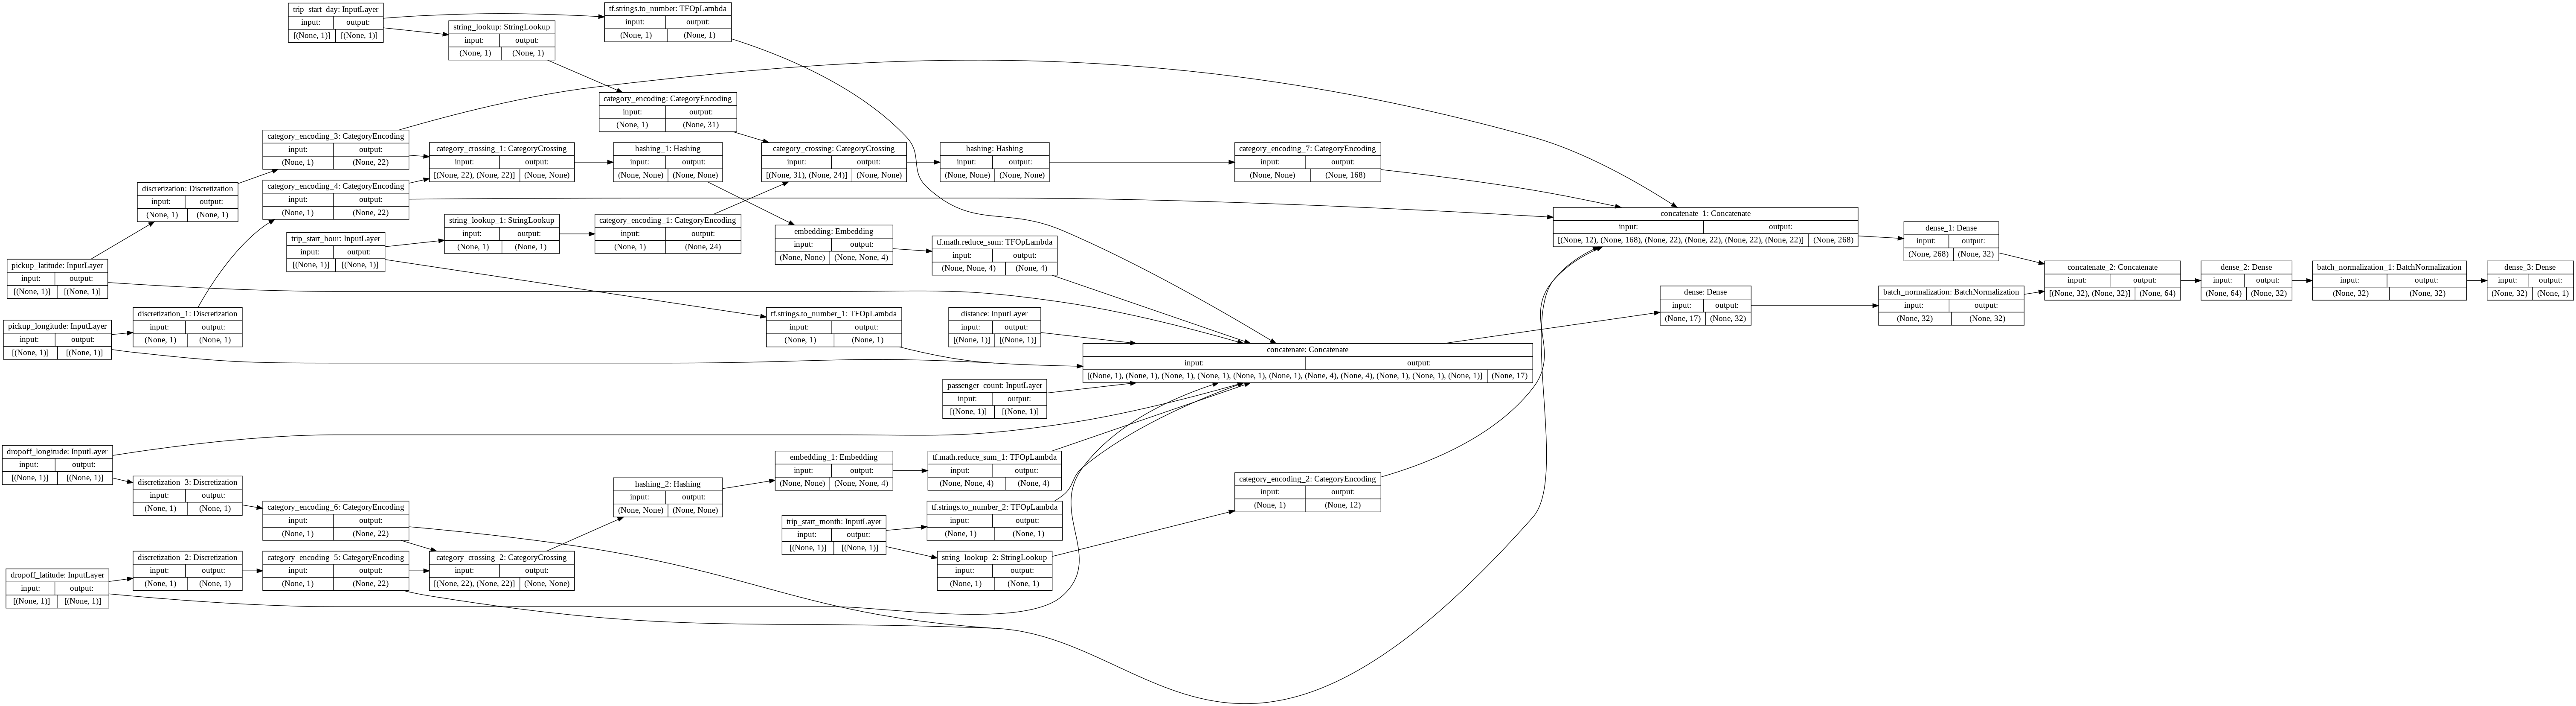

In [34]:
#Create dataset input functions
train_dataset = make_input_fn(filename = '/content/drive/MyDrive/new-york-city-taxi-fare-prediction/Copy of train.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 512)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [35]:
# !rm -rf "./logs"
# %tensorboard --logdir "./logs"

keras_train_and_evaluate(m_, train_dataset, validation_dataset, 50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['key', 'pickup_datetime', 'trip_start_year'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


100/100 [==============================] - 29s 250ms/step - loss: 199.6859 - rmse: 14.1257 - val_loss: 162.9703 - val_rmse: 12.7659
Epoch 2/50
100/100 [==============================] - 23s 225ms/step - loss: 148.2281 - rmse: 12.1659 - val_loss: 100.9368 - val_rmse: 10.0467
Epoch 3/50
100/100 [==============================] - 22s 225ms/step - loss: 103.7955 - rmse: 10.1856 - val_loss: 93.6329 - val_rmse: 9.6764
Epoch 4/50
100/100 [==============================] - 22s 225ms/step - loss: 83.9093 - rmse: 9.1552 - val_loss: 166.6915 - val_rmse: 12.9109
Epoch 5/50
100/100 [==============================] - 22s 225ms/step - loss: 64.4352 - rmse: 8.0235 - val_loss: 136.4501 - val_rmse: 11.6812
Epoch 6/50
100/100 [==============================] - 23s 225ms/step - loss: 60.9075 - rmse: 7.8021 - val_loss: 124.6432 - val_rmse: 11.1643
Epoch 7/50
100/100 [==============================] - 22s 224ms/step - loss: 54.2336 - rmse: 7.3607 - val_loss: 89.3764 - val_rmse: 9.4539
Epoch 8/50
100/100 [==

# ## Prediction directly using model's instance

In [36]:
# ## Prediction directly using model's instance
# ## BUT HERE ALL FEATURES HAVE TO BE PASSED, EVEN THE Calculated ones
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'trip_start_day': [["1"]],
                         'trip_start_hour': [["5"]],
                         'trip_start_month': [["6"]],
                         'distance':[[0.04196861]],
                         'passenger_count':[[2.0]]
                         })

m_.predict(data)

array([[21.009779]], dtype=float32)

In [37]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude,date,passenger_count):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)
    trip_start_month = tf.strings.substr(date,5,2)
    trip_start_day = tf.strings.substr(date,8,2)
    trip_start_hour = tf.strings.substr(date,11,2)
    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'trip_start_day': trip_start_day,
        'trip_start_hour': trip_start_hour,
        'trip_start_month': trip_start_month,
        'distance': distance,
        'passenger_count': passenger_count
    }
    
    ## Predict
    ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(date=tf.TensorSpec([None,], dtype=tf.string, name='pickup_datetime'),
                                        passenger_count=tf.TensorSpec([None,],dtype=tf.float32, name='passenger_count') ,
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 

# tf.saved_model.save(
#     m_,
#     "./exported_model/" + version,
#     signatures={'serving_default': serving}
# ) 

INFO:tensorflow:Assets written to: ./exported_model/1/assets


In [38]:
# !zip -r /content/model.zip /content/exported_model/1
!tar -cvf /content/model.tar /content/exported_model/1/

tar: Removing leading `/' from member names
/content/exported_model/1/
/content/exported_model/1/assets/
/content/exported_model/1/saved_model.pb
/content/exported_model/1/variables/
/content/exported_model/1/variables/variables.data-00000-of-00001
/content/exported_model/1/variables/variables.index


In [39]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dropoff_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_latitude:0
    inputs['dropoff_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_longitude:0
    inputs['passenger_count'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_passenger_count:0
    inputs['pickup_datetime'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
 

In [40]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), pickup_datetime=tf.convert_to_tensor(["2009-06-15 17:26:21"]), passenger_count=tf.convert_to_tensor([5.0]))

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[23.720259]], dtype=float32)>}

In [41]:
###Install TF Model server

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package tensorflow-model-server
deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  54500      0 --:--:-- --:--:-- --:--:-- 54500
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-lear

In [42]:
###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

In [43]:
!tail server.log

In [ ]:
import json
import requests

#Create payload
data_py = {"instances":[{'dropoff_latitude': 41.920452,
                         'dropoff_longitude': -87.679955,
                         'pickup_latitude': 41.952823,
                         'pickup_longitude': -87.653244,
                         'trip_start_day': "1",
                         'trip_start_hour': "5",
                         'trip_start_month': "6"}]}

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)
json_response.text